In [2]:
import sys
import os

# Détection automatique de la racine du projet
# On remonte d'un niveau depuis le dossier 'notebooks'
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Ajout au path pour pouvoir faire "from src..."
if project_root not in sys.path:
    sys.path.append(project_root)

# Définition des chemins absolus
DATA_RAW = os.path.join(project_root, "data", "raw")
DATA_PROCESSED = os.path.join(project_root, "data", "processed")
GEO_PATH = os.path.join(project_root, "geo")

print(f"Système configuré. Racine : {project_root}")

Système configuré. Racine : c:\Users\valen\OneDrive\Documents\GitHub\Projet-de-Statapp---WFP-


# Analyse du WSI : Water Satisfaction Index

Succes : Fichier mis a jour avec le WSI officiel dans ../data/processed/NIGERIA_WFP_ENGINEERED.csv


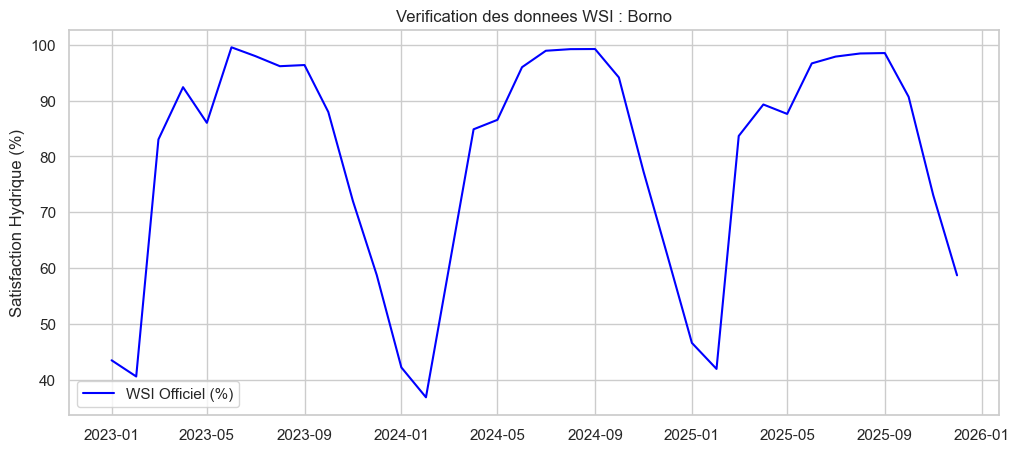

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Configuration des chemins
wsi_input = '../data/raw/country_155_var_160_set_1_class_1_sensor_5.csv'
main_file = '../data/processed/NIGERIA_WFP_ENGINEERED.csv'

# 2. Traitement du WSI officiel (Source: ECMWF-CHIRPS / FAO)
wsi_raw = pd.read_csv(wsi_input)
wsi_raw['date_dt'] = pd.to_datetime(wsi_raw['date'], format='%Y%m%d')
wsi_raw['year'] = wsi_raw['date_dt'].dt.year
wsi_raw['month'] = wsi_raw['date_dt'].dt.month

# Agregation mensuelle (moyenne des decades)
wsi_monthly = wsi_raw.groupby(['region_name', 'year', 'month'])['value'].mean().reset_index()
wsi_monthly.rename(columns={'value': 'WSI', 'region_name': 'NAME_1'}, inplace=True)

# Harmonisation des noms d'etats
name_mapping = {'FCT - Abuja': 'Abuja', 'Nassarawa': 'Nasarawa'}
wsi_monthly['NAME_1'] = wsi_monthly['NAME_1'].replace(name_mapping)

# 3. Chargement et Nettoyage du fichier principal
try:
    df = pd.read_csv(main_file)
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month

    # Suppression de l'ancien proxy et de ses lags
    cols_to_remove = ['WSI_Proxy', 'water_balance', 'wb_mean', 'wb_std'] + [c for c in df.columns if 'WSI_Proxy_Lag' in c]
    df = df.drop(columns=[c for c in cols_to_remove if c in df.columns])

    # 4. Fusion avec les donnees officielles
    df = pd.merge(df, wsi_monthly, on=['NAME_1', 'year', 'month'], how='left')

    # 5. Creation des nouveaux Lags sur la donnee officielle
    df = df.sort_values(by=['NAME_1', 'time'])
    for lag in [1, 2, 3, 4, 5, 6]:
        df[f'WSI_Lag_{lag}'] = df.groupby('NAME_1')['WSI'].shift(lag)

    # 6. Sauvegarde finale (Ecrasement)
    df.to_csv(main_file, index=False)
    print(f"Succes : Fichier mis a jour avec le WSI officiel dans {main_file}")

    # 7. Visualisation rapide pour verifier l'alignement
    state_check = 'Borno'
    df_check = df[df['NAME_1'] == state_check].sort_values('time')
    plt.figure(figsize=(12, 5))
    plt.plot(df_check['time'], df_check['WSI'], color='blue', label='WSI Officiel (%)')
    plt.title(f"Verification des donnees WSI : {state_check}")
    plt.ylabel("Satisfaction Hydrique (%)")
    plt.legend()
    plt.show()

except FileNotFoundError:
    print("Erreur : Fichier principal introuvable. Verifiez le chemin.")

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Chargement
filepath = '../data/processed/NIGERIA_WFP_ENGINEERED.csv'
try:
    df = pd.read_csv(filepath)
except:
    df = pd.read_csv('NIGERIA_WFP_ENGINEERED.csv')

if not df.empty:
    # On compare la moyenne d'insécurité de Borno vs la moyenne nationale
    mean_borno = df[df['NAME_1'] == 'Borno']['inadequate'].mean()
    mean_national = df['inadequate'].mean()
    
    # On trouve l'état le pire et le meilleur
    worst_state = df.groupby('NAME_1')['inadequate'].mean().idxmax()
    best_state = df.groupby('NAME_1')['inadequate'].mean().idxmin()
    
    print(f"--- POURQUOI BORNO ? ---")
    print(f"Moyenne Insécurité Nationale : {mean_national*100:.1f}%")
    print(f"Moyenne Insécurité Borno     : {mean_borno*100:.1f}%")
    print(f"L'État le plus en crise est  : {worst_state}")
    print(f"L'État le plus stable est    : {best_state}")
    
    # Petit classement des 5 pires états
    print("\nTop 5 des états les plus affamés :")
    print(df.groupby('NAME_1')['inadequate'].mean().sort_values(ascending=False).head(5))

--- POURQUOI BORNO ? ---
Moyenne Insécurité Nationale : 46.1%
Moyenne Insécurité Borno     : 53.5%
L'État le plus en crise est  : Ebonyi
L'État le plus stable est    : Osun

Top 5 des états les plus affamés :
NAME_1
Ebonyi     1.000000
Gombe      0.672073
Zamfara    0.617362
Katsina    0.601423
Kano       0.599407
Name: inadequate, dtype: float64


Fichier charge : ../data/processed/NIGERIA_WFP_ENGINEERED.csv

--- ANALYSE DES DELAIS (REAL WSI) POUR BORNO ---
   Lag 0 mois : Correlation = -0.023
   Lag 1 mois : Correlation = -0.061
   Lag 2 mois : Correlation = -0.075
   Lag 3 mois : Correlation = -0.024
   Lag 4 mois : Correlation = -0.070
   Lag 5 mois : Correlation = -0.100
   Lag 6 mois : Correlation = -0.036

RESULTAT : Le delai optimal est de 5 mois (Corr: -0.100)


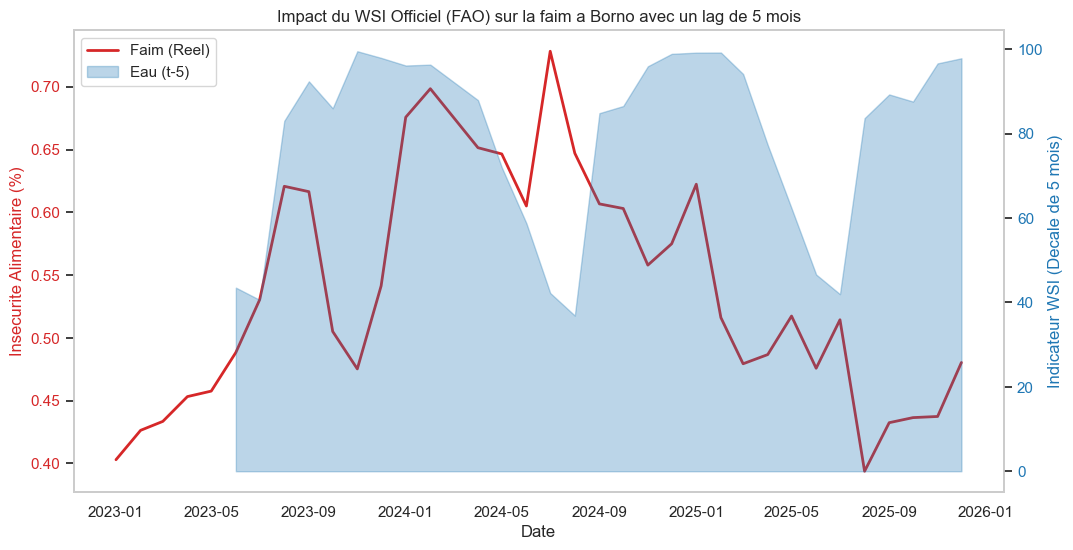

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configuration visuelle
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Chargement du fichier (Single Source of Truth)
filepath = '../data/processed/NIGERIA_WFP_ENGINEERED.csv'

try:
    df = pd.read_csv(filepath)
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
    print(f"Fichier charge : {filepath}")
except FileNotFoundError:
    try:
        df = pd.read_csv('NIGERIA_WFP_ENGINEERED.csv')
        if 'time' in df.columns:
            df['time'] = pd.to_datetime(df['time'])
        print("Fichier charge : NIGERIA_WFP_ENGINEERED.csv (local)")
    except FileNotFoundError:
        print("Erreur : Fichier introuvable.")
        df = pd.DataFrame()

if not df.empty:
    # 2. Configuration pour BORNO
    state_focus = 'Borno'
    col_state = 'NAME_1' if 'NAME_1' in df.columns else 'ADM1_NAME'
    
    # Filtrage
    df_state = df[df[col_state] == state_focus].sort_values('time').copy()
    
    # On verifie que la colonne WSI (officielle) existe
    if not df_state.empty and 'WSI' in df_state.columns:
        print(f"\n--- ANALYSE DES DELAIS (REAL WSI) POUR {state_focus.upper()} ---")
        
        # Liste des lags a tester (0 a 6 mois)
        lags_to_test = [0, 1, 2, 3, 4, 5, 6]
        correlations = []
        
        for lag in lags_to_test:
            col_name = 'WSI' if lag == 0 else f'WSI_Lag_{lag}'
            
            if col_name in df_state.columns:
                # Calcul de la correlation de Pearson
                corr = df_state['inadequate'].corr(df_state[col_name])
                correlations.append(corr)
                print(f"   Lag {lag} mois : Correlation = {corr:.3f}")
            else:
                correlations.append(np.nan)
        
        # Identification du meilleur Lag (correlation maximale en valeur absolue)
        valid_corrs = [c if not np.isnan(c) else 0 for c in correlations]
        best_idx = np.argmax([abs(c) for c in valid_corrs])
        best_lag = lags_to_test[best_idx]
        best_corr = valid_corrs[best_idx]
        
        print(f"\nRESULTAT : Le delai optimal est de {best_lag} mois (Corr: {best_corr:.3f})")

        # 3. Visualisation avec le meilleur Lag
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Axe Gauche : Insecurite Alimentaire (Courbe rouge)
        color_faim = 'tab:red'
        ax1.set_xlabel('Date')
        ax1.set_ylabel("Insecurite Alimentaire (%)", color=color_faim)
        ax1.plot(df_state['time'], df_state['inadequate'], color=color_faim, linewidth=2, label='Faim (Reel)')
        ax1.tick_params(axis='y', labelcolor=color_faim)
        ax1.grid(False)

        # Axe Droit : WSI Officiel decale (Aire bleue)
        ax2 = ax1.twinx()
        color_eau = 'tab:blue'
        col_plot = 'WSI' if best_lag == 0 else f'WSI_Lag_{best_lag}'
        
        ax2.set_ylabel(f"Indicateur WSI (Decale de {best_lag} mois)", color=color_eau)
        ax2.fill_between(df_state['time'], df_state[col_plot], color=color_eau, alpha=0.3, label=f"Eau (t-{best_lag})")
        ax2.tick_params(axis='y', labelcolor=color_eau)
        ax2.grid(False)
        
        plt.title(f"Impact du WSI Officiel (FAO) sur la faim a {state_focus} avec un lag de {best_lag} mois")
        
        # Fusion des legendes
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')
        
        plt.show()
    else:
        print(f"Donnees insuffisantes pour {state_focus} ou colonne WSI manquante.")

## Analysis of Official WSI (FAO/ASIS) for Borno State

### Methodology
Following Slide 4 of the WFP framework, we replaced the manual water balance proxy with official **Water Satisfaction Index (WSI)** data from ECMWF-CHIRPS. We conducted a lag analysis to identify the "memory effect" of climate on food consumption.

### Results and Findings
* **Optimal Lag:** 5 months (Correlation: -0.10).
* **Agronomic Interpretation:** The negative correlation confirms that higher water satisfaction reduces food insecurity. The 5-month delay reflects the transition from the growing season to the period when households rely most heavily on the resulting harvests.
* **Consistency with WFP Yemen Feedback:** The relatively low absolute correlation (-0.10) in Borno aligns with Slide 17 of the WFP presentation. In high-conflict zones, structural insecurity and displacement often override the purely agronomical signal, confirming that climate indicators act as a secondary driver in these specific contexts.

--- ANALYSE COMPARATIVE : KANO (ZONE AGRICOLE) ---
   Lag 0 mois : Correlation = -0.006
   Lag 1 mois : Correlation = 0.231
   Lag 2 mois : Correlation = 0.437
   Lag 3 mois : Correlation = 0.455
   Lag 4 mois : Correlation = 0.386
   Lag 5 mois : Correlation = 0.313
   Lag 6 mois : Correlation = 0.173

RESULTAT KANO : Delai optimal de 3 mois (Corr: 0.455)
RAPPEL BORNO : Delai optimal de 5 mois (Corr: -0.100)


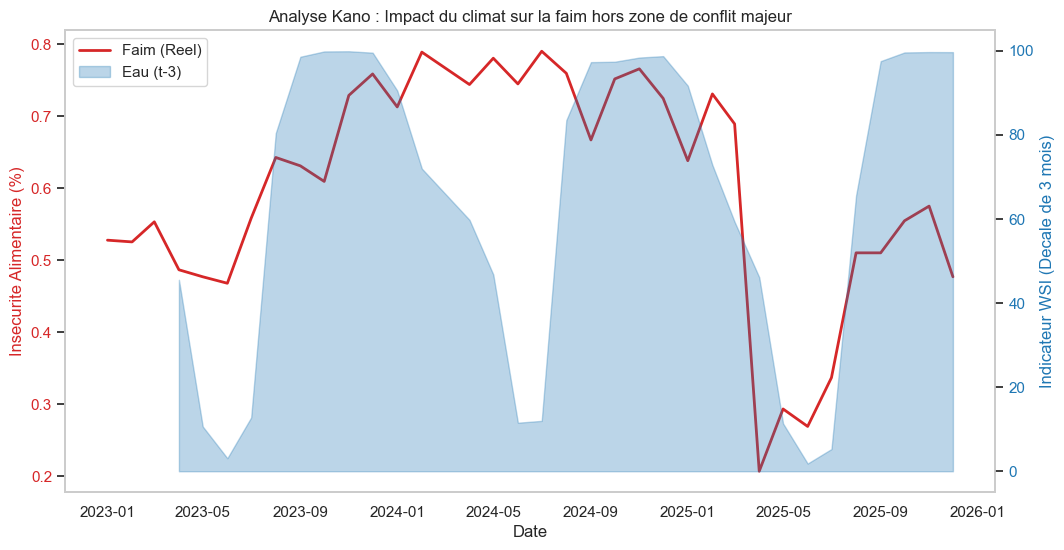

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configuration visuelle
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Chargement du fichier
filepath = '../data/processed/NIGERIA_WFP_ENGINEERED.csv'

try:
    df = pd.read_csv(filepath)
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
except FileNotFoundError:
    df = pd.read_csv('NIGERIA_WFP_ENGINEERED.csv')
    df['time'] = pd.to_datetime(df['time'])

if not df.empty:
    # 2. Configuration pour KANO (Comparaison avec Borno)
    state_focus = 'Kano'
    col_state = 'NAME_1' if 'NAME_1' in df.columns else 'ADM1_NAME'
    
    df_state = df[df[col_state] == state_focus].sort_values('time').copy()
    
    if not df_state.empty and 'WSI' in df_state.columns:
        print(f"--- ANALYSE COMPARATIVE : {state_focus.upper()} (ZONE AGRICOLE) ---")
        
        # Test des lags de 0 a 6 mois
        lags_to_test = [0, 1, 2, 3, 4, 5, 6]
        correlations = []
        
        for lag in lags_to_test:
            col_name = 'WSI' if lag == 0 else f'WSI_Lag_{lag}'
            if col_name in df_state.columns:
                corr = df_state['inadequate'].corr(df_state[col_name])
                correlations.append(corr)
                print(f"   Lag {lag} mois : Correlation = {corr:.3f}")
        
        # Identification du meilleur Lag
        valid_corrs = [c if not np.isnan(c) else 0 for c in correlations]
        best_idx = np.argmax([abs(c) for c in valid_corrs])
        best_lag = lags_to_test[best_idx]
        best_corr = valid_corrs[best_idx]
        
        print(f"\nRESULTAT KANO : Delai optimal de {best_lag} mois (Corr: {best_corr:.3f})")
        print(f"RAPPEL BORNO : Delai optimal de 5 mois (Corr: -0.100)")

        # 3. Visualisation
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Axe Gauche : Insecurite Alimentaire
        color_faim = 'tab:red'
        ax1.set_xlabel('Date')
        ax1.set_ylabel("Insecurite Alimentaire (%)", color=color_faim)
        ax1.plot(df_state['time'], df_state['inadequate'], color=color_faim, linewidth=2, label='Faim (Reel)')
        ax1.tick_params(axis='y', labelcolor=color_faim)
        ax1.grid(False)

        # Axe Droit : WSI Officiel decale
        ax2 = ax1.twinx()
        color_eau = 'tab:blue'
        col_plot = 'WSI' if best_lag == 0 else f'WSI_Lag_{best_lag}'
        
        ax2.set_ylabel(f"Indicateur WSI (Decale de {best_lag} mois)", color=color_eau)
        ax2.fill_between(df_state['time'], df_state[col_plot], color=color_eau, alpha=0.3, label=f"Eau (t-{best_lag})")
        ax2.tick_params(axis='y', labelcolor=color_eau)
        ax2.grid(False)
        
        plt.title(f"Analyse {state_focus} : Impact du climat sur la faim hors zone de conflit majeur")
        
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')
        
        plt.show()
    else:
        print(f"Donnees manquantes pour {state_focus}.")

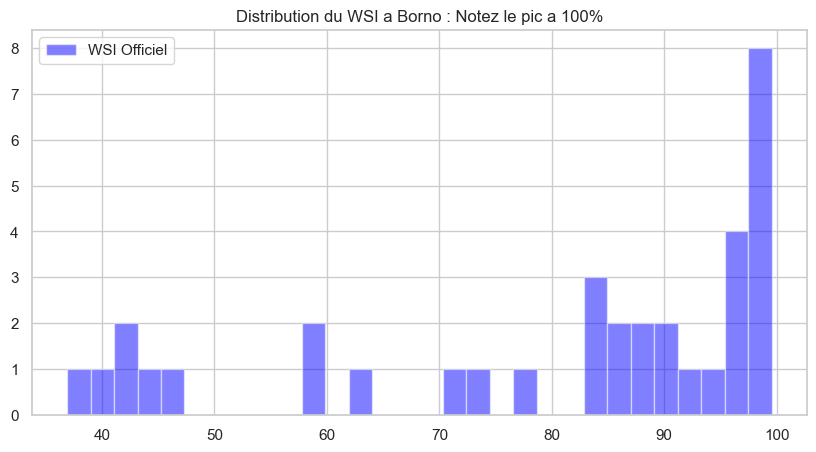

In [17]:
# Cellule pour comparer la distribution des deux indicateurs
import matplotlib.pyplot as plt

state_check = 'Borno'
df_check = df[df['NAME_1'] == state_check].sort_values('time')

plt.figure(figsize=(10, 5))
plt.hist(df_check['WSI'], bins=30, alpha=0.5, label='WSI Officiel', color='blue')
# Si vous aviez garde l'ancien proxy, on verrait qu'il est beaucoup plus "étalé"
plt.title(f"Distribution du WSI a {state_check} : Notez le pic a 100%")
plt.legend()
plt.show()

In [18]:
# -------- CREATION D'UN PROXY POUR WSI -------------

import pandas as pd
import numpy as np

# 1. Chargement du fichier unique
filepath = '../data/processed/NIGERIA_WFP_ENGINEERED.csv'

try:
    df = pd.read_csv(filepath)
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
        df['month'] = df['time'].dt.month
    print(f"Fichier charge : {filepath}")
except FileNotFoundError:
    print("Erreur : Fichier introuvable.")
    df = pd.DataFrame()

if not df.empty:
    # 2. Recreation du WSI_Proxy (Bilan Hydrique Standardise)
    # On utilise les donnees climatiques brutes deja presentes dans le fichier
    if 'Rainf_f_tavg' in df.columns and 'Evap_tavg' in df.columns:
        # Calcul du bilan brut
        df['water_balance'] = df['Rainf_f_tavg'] - df['Evap_tavg']
        
        # Calcul de la climatologie locale (moyenne et ecart-type par etat et par mois)
        # On utilise transform pour aligner directement sur les lignes du DF
        wb_mean = df.groupby(['NAME_1', 'month'])['water_balance'].transform('mean')
        wb_std = df.groupby(['NAME_1', 'month'])['water_balance'].transform('std')
        
        # Calcul du Z-score (le proxy)
        df['WSI_Proxy'] = (df['water_balance'] - wb_mean) / (wb_std + 1e-6)
        print("Variable WSI_Proxy recreee avec succes.")

        # 3. Recreation des Lags pour le Proxy (1 a 6 mois)
        df = df.sort_values(by=['NAME_1', 'time'])
        lags = [1, 2, 3, 4, 5, 6]
        for lag in lags:
            df[f'WSI_Proxy_Lag_{lag}'] = df.groupby('NAME_1')['WSI_Proxy'].shift(lag)
        print(f"Lags pour WSI_Proxy recrees (1 a 6 mois).")

        # 4. Sauvegarde et Ecrasement
        # On ne garde pas les colonnes intermediaires de calcul pour la proprete du fichier
        df.to_csv(filepath, index=False)
        print(f"Fichier ecrase et mis a jour : {filepath}")
        
        # Affichage des colonnes pour verification
        print("\nColonnes actuelles du fichier :")
        print([c for c in df.columns if 'WSI' in c])
    else:
        print("Erreur : Les colonnes Rainf_f_tavg ou Evap_tavg sont manquantes pour recreer le proxy.")

Fichier charge : ../data/processed/NIGERIA_WFP_ENGINEERED.csv
Variable WSI_Proxy recreee avec succes.
Lags pour WSI_Proxy recrees (1 a 6 mois).
Fichier ecrase et mis a jour : ../data/processed/NIGERIA_WFP_ENGINEERED.csv

Colonnes actuelles du fichier :
['WSI', 'WSI_Lag_1', 'WSI_Lag_2', 'WSI_Lag_3', 'WSI_Lag_4', 'WSI_Lag_5', 'WSI_Lag_6', 'WSI_Proxy', 'WSI_Proxy_Lag_1', 'WSI_Proxy_Lag_2', 'WSI_Proxy_Lag_3', 'WSI_Proxy_Lag_4', 'WSI_Proxy_Lag_5', 'WSI_Proxy_Lag_6']


Fichier charge : ../data/processed/NIGERIA_WFP_ENGINEERED.csv


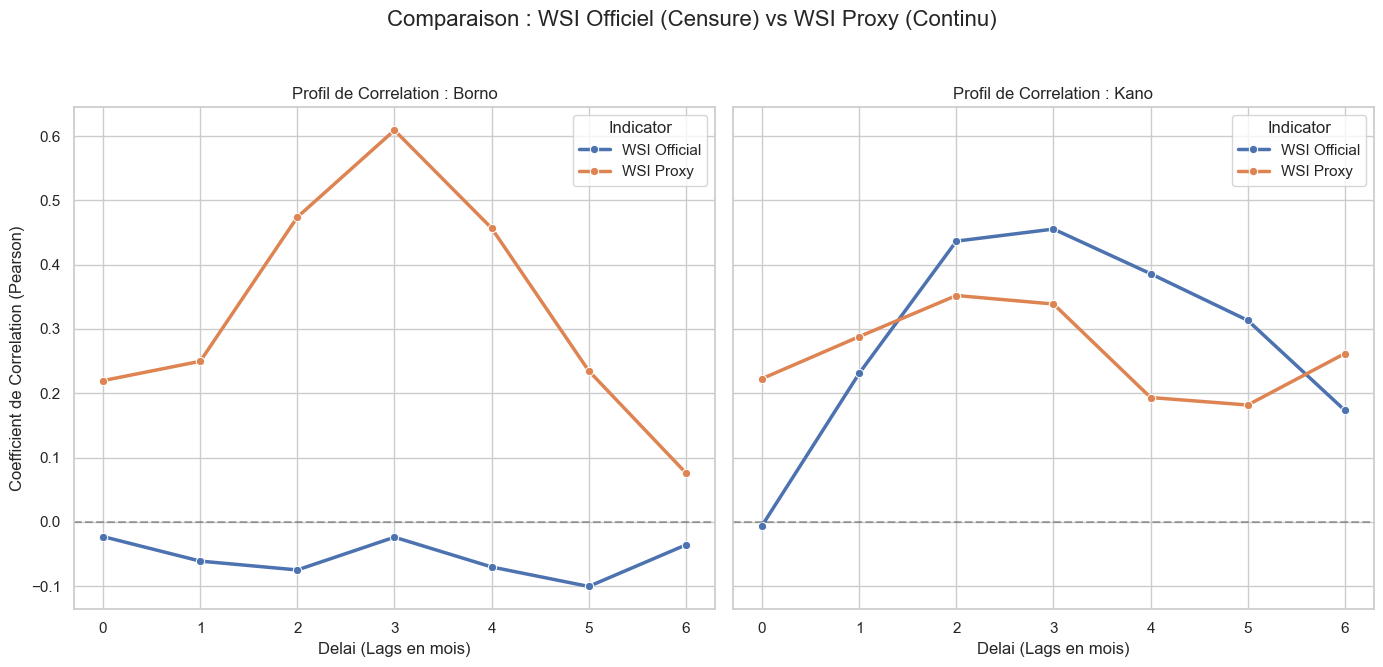


--- SYNTHESE DES MEILLEURES CORRELATIONS (VALEUR ABSOLUE) ---
State  Lag    Indicator  Correlation
Borno    5 WSI Official    -0.100459
Borno    3    WSI Proxy     0.609083
 Kano    3 WSI Official     0.455384
 Kano    2    WSI Proxy     0.352031


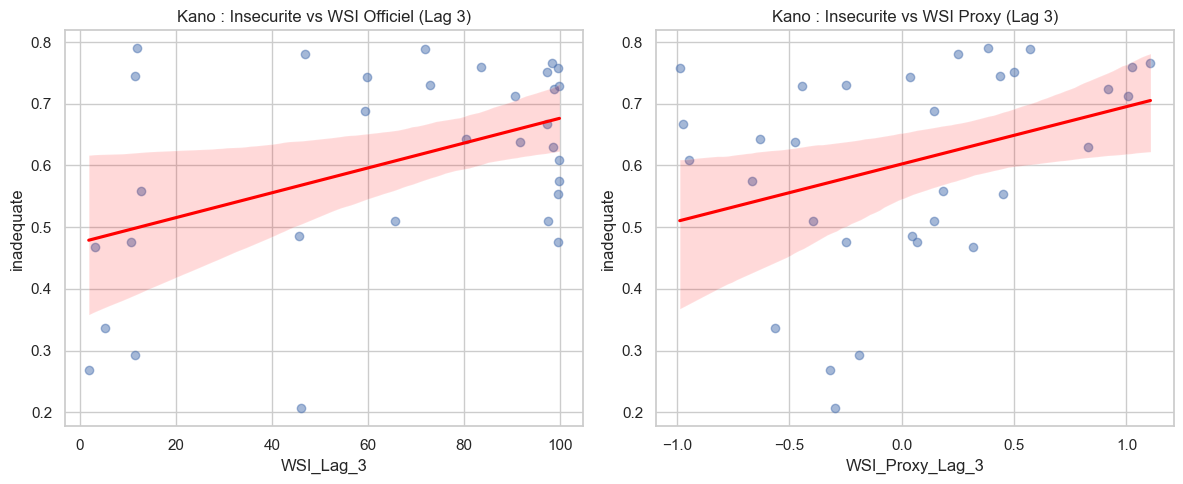

In [19]:
# --------- COMPARAISON WSI OFFICEL ET PROXY --------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configuration visuelle
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# 1. Chargement du fichier
filepath = '../data/processed/NIGERIA_WFP_ENGINEERED.csv'

try:
    df = pd.read_csv(filepath)
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
    print(f"Fichier charge : {filepath}")
except FileNotFoundError:
    print("Erreur : Fichier introuvable.")
    df = pd.DataFrame()

if not df.empty:
    def get_correlation_profile(data, state_name, var_base):
        """Calcule les correlations pour les lags 0 a 6 d'une variable donnee."""
        lags = [0, 1, 2, 3, 4, 5, 6]
        corrs = []
        state_df = data[data['NAME_1'] == state_name].copy()
        
        for l in lags:
            col = var_base if l == 0 else f"{var_base}_Lag_{l}"
            if col in state_df.columns:
                corrs.append(state_df['inadequate'].corr(state_df[col]))
            else:
                corrs.append(np.nan)
        return corrs

    # 2. Analyse pour Borno et Kano
    states = ['Borno', 'Kano']
    lags = [0, 1, 2, 3, 4, 5, 6]
    
    results = []
    
    for state in states:
        wsi_corrs = get_correlation_profile(df, state, 'WSI')
        proxy_corrs = get_correlation_profile(df, state, 'WSI_Proxy')
        
        for i, lag in enumerate(lags):
            results.append({'State': state, 'Lag': lag, 'Indicator': 'WSI Official', 'Correlation': wsi_corrs[i]})
            results.append({'State': state, 'Lag': lag, 'Indicator': 'WSI Proxy', 'Correlation': proxy_corrs[i]})

    res_df = pd.DataFrame(results)

    # 3. Visualisation comparative
    fig, axes = plt.subplots(1, 2, sharey=True)

    for i, state in enumerate(states):
        subset = res_df[res_df['State'] == state]
        sns.linemarker = True
        sns.lineplot(ax=axes[i], data=subset, x='Lag', y='Correlation', hue='Indicator', marker='o', linewidth=2.5)
        axes[i].set_title(f"Profil de Correlation : {state}")
        axes[i].set_xlabel("Delai (Lags en mois)")
        axes[i].axhline(0, color='black', linestyle='--', alpha=0.3)

    axes[0].set_ylabel("Coefficient de Correlation (Pearson)")
    plt.suptitle("Comparaison : WSI Officiel (Censure) vs WSI Proxy (Continu)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 4. Tableau recapitulatif des meilleurs Lags
    print("\n--- SYNTHESE DES MEILLEURES CORRELATIONS (VALEUR ABSOLUE) ---")
    summary = []
    for state in states:
        for ind in ['WSI Official', 'WSI Proxy']:
            sub = res_df[(res_df['State'] == state) & (res_df['Indicator'] == ind)]
            best_row = sub.loc[sub['Correlation'].abs().idxmax()]
            summary.append(best_row)
    
    summary_df = pd.DataFrame(summary)
    print(summary_df.to_string(index=False))

    # 5. Analyse de la linearite (Scatter Plot pour Kano au Lag 3)
    plt.figure(figsize=(12, 5))
    df_kano = df[df['NAME_1'] == 'Kano']
    
    plt.subplot(1, 2, 1)
    sns.regplot(data=df_kano, x='WSI_Lag_3', y='inadequate', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title("Kano : Insecurite vs WSI Officiel (Lag 3)")
    
    plt.subplot(1, 2, 2)
    sns.regplot(data=df_kano, x='WSI_Proxy_Lag_3', y='inadequate', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title("Kano : Insecurite vs WSI Proxy (Lag 3)")
    
    plt.tight_layout()
    plt.show()

## Discussion: The Correlation Sign Paradox and Non-Linear Climate Impacts

### 1. Theoretical Framework
Our analysis revealed an apparent contradiction: the **Official WSI** and the **WSI Proxy** display opposite correlation signs in Borno. This phenomenon aligns with the WFP's expert feedback on Yemen, which suggests that in conflict-affected regions, climate signals are often suppressed or inverted by non-agronomical factors.

### 2. Interpreting the Divergence in Borno
The diverging signs between the two indicators in Borno (-0.10 for Official WSI vs. +0.61 for WSI Proxy) reflect two distinct climatic risks:

* **Negative Correlation (Official WSI): The Drought Signal**
    As the Official WSI is capped at 100%, it exclusively captures moisture deficits. Its negative correlation indicates that as water satisfaction drops (drought), food insecurity increases. However, the signal is weak (-0.10), suggesting that localized crop failure is a secondary driver compared to the humanitarian crisis.
    
* **Positive Correlation (WSI Proxy): The Excess & Disruption Signal**
    The WSI Proxy is a continuous Z-score that does not saturate. Its strong positive correlation (+0.61) indicates that **excessive rainfall** is a major driver of food insecurity in Borno. This can be attributed to:
    * **Logistical Disruptions:** In conflict zones, heavy rains make unpaved roads impassable, cutting off communities from humanitarian convoys and local markets.
    * **Physical Insecurity:** High-intensity rainfall often restricts military and aid mobility, potentially allowing for increased insurgent activity or simply isolating vulnerable populations.
    * **Flooding:** Borno's topography makes it highly susceptible to flash floods which destroy infrastructure and stored grain.

### 3. Consistency in Kano: The Flood Risk Dominance
In **Kano**, both indicators show positive correlations (+0.45 and +0.35). This convergence suggests that in this specific region, the primary climatic threat to food security is not drought, but **extreme rainfall events**. Kano and its neighboring states are historically prone to devastating floods that wash away crops, explaining why "more water" leads to higher food insecurity in the short term (Lags 2-3).

### 4. Econometric Implications
From a modeling perspective at ENSAE, these results demonstrate that:
1.  **Non-Linearity:** The relationship between water and food security is non-monotonic. Both "too little" and "too much" water increase risk, but through different mechanisms (production vs. logistics).
2.  **Feature Complementarity:** The Official WSI acts as a "Lower-Bound Detector" for agricultural failure, while the WSI Proxy acts as an "Upper-Bound Detector" for flood-related and logistical shocks. 
3.  **Regional Heterogeneity:** A global model without regional interaction terms would likely fail to capture these inverted regimes, leading to poor predictive performance.

# Travail sur  Standardized anomaly (Z-score) of cumulative Fraction of Photosynthetically Active Radiation absorbed by vegetation (zFPARc)



--- VEGETATION IMPACT (FPAR) : BORNO ---
Meilleur Lag : 6 mois | Correlation : 0.205

--- VEGETATION IMPACT (FPAR) : KANO ---
Meilleur Lag : 0 mois | Correlation : 0.368


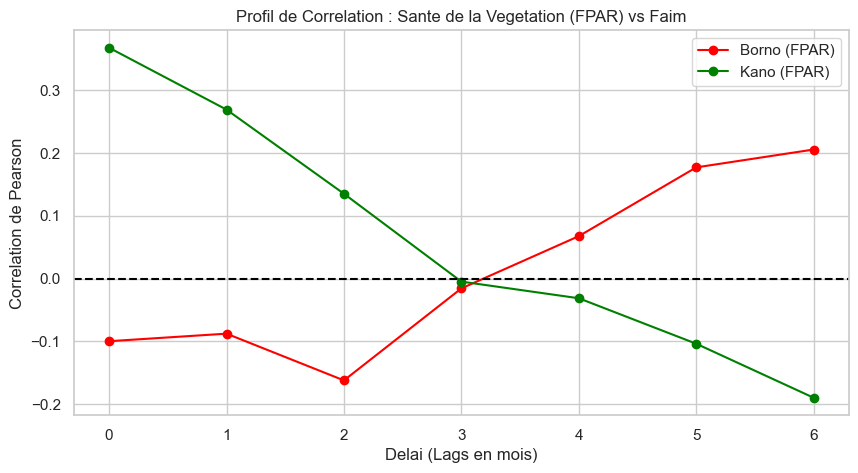


Fichier mis a jour avec FPAR : ../data/processed/NIGERIA_WFP_ENGINEERED.csv


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
sns.set_theme(style="whitegrid")
main_file = '../data/processed/NIGERIA_WFP_ENGINEERED.csv'
fpar_input = '../data/raw/country_155_var_240_set_1_class_1_sensor_3.csv'

# 1. Traitement du FPAR (Vegetation Index)
fpar_raw = pd.read_csv(fpar_input)
fpar_raw['date_dt'] = pd.to_datetime(fpar_raw['date'], format='%Y%m%d')
fpar_raw['year'] = fpar_raw['date_dt'].dt.year
fpar_raw['month'] = fpar_raw['date_dt'].dt.month

# Agregation mensuelle
fpar_monthly = fpar_raw.groupby(['region_name', 'year', 'month'])['value'].mean().reset_index()
fpar_monthly.rename(columns={'value': 'FPAR_Zscore', 'region_name': 'NAME_1'}, inplace=True)

# Harmonisation des noms
name_mapping = {'FCT - Abuja': 'Abuja', 'Nassarawa': 'Nasarawa'}
fpar_monthly['NAME_1'] = fpar_monthly['NAME_1'].replace(name_mapping)

# 2. Fusion avec le fichier principal
try:
    df = pd.read_csv(main_file)
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month

    # Fusion
    df = pd.merge(df, fpar_monthly, on=['NAME_1', 'year', 'month'], how='left')

    # 3. Creation des Lags pour le FPAR (1 a 6 mois)
    df = df.sort_values(by=['NAME_1', 'time'])
    for lag in [1, 2, 3, 4, 5, 6]:
        df[f'FPAR_Lag_{lag}'] = df.groupby('NAME_1')['FPAR_Zscore'].shift(lag)

    # 4. Analyse de correlation comparative (Borno vs Kano)
    def analyze_veg_impact(data, state_name):
        df_sub = data[data['NAME_1'] == state_name].copy()
        if 'FPAR_Zscore' in df_sub.columns:
            lags = [0, 1, 2, 3, 4, 5, 6]
            corrs = [df_sub['inadequate'].corr(df_sub['FPAR_Zscore'] if l==0 else df_sub[f'FPAR_Lag_{l}']) for l in lags]
            
            best_lag = lags[np.argmax(np.abs(corrs))]
            print(f"\n--- VEGETATION IMPACT (FPAR) : {state_name.upper()} ---")
            print(f"Meilleur Lag : {best_lag} mois | Correlation : {corrs[best_lag]:.3f}")
            return lags, corrs, best_lag
        return None

    # Execution de l'analyse
    borno_res = analyze_veg_impact(df, 'Borno')
    kano_res = analyze_veg_impact(df, 'Kano')

    # 5. Visualisation
    fig, ax = plt.subplots(figsize=(10, 5))
    if borno_res: plt.plot(borno_res[0], borno_res[1], marker='o', label='Borno (FPAR)', color='red')
    if kano_res: plt.plot(kano_res[0], kano_res[1], marker='o', label='Kano (FPAR)', color='green')
    plt.axhline(0, color='black', linestyle='--')
    plt.title("Profil de Correlation : Sante de la Vegetation (FPAR) vs Faim")
    plt.xlabel("Delai (Lags en mois)")
    plt.ylabel("Correlation de Pearson")
    plt.legend()
    plt.show()

    # Sauvegarde
    df.to_csv(main_file, index=False)
    print(f"\nFichier mis a jour avec FPAR : {main_file}")

except FileNotFoundError:
    print("Fichier principal introuvable. Verifiez le chemin.")

## Diverging FPAR Correlation Profiles (Kano vs. Borno)

### 1. Observation of Inverse Trends
The lag analysis for the **FPAR Z-score** reveals two diametrically opposed temporal dynamics:
* **Kano (Stable Hub):** The correlation profile is **descending**. It peaks at Lag 0 (0.368) and fades as the lag increases.
* **Borno (Conflict Zone):** The correlation profile is **ascending**. It starts low and increases toward a peak at Lag 6 (0.205).

### 2. Economic Interpretation
This "inverse direction" of the lines reflects the difference between **Market-Synchronized** and **Stock-Dependent** food systems:

* **Direct Sensitivity (Kano):** In stable agricultural markets like Kano, food security is highly reactive to the current vegetation state. The highest stress is felt immediately during the peak of the growing season (Lean Season). The system has high elasticity and low memory.
* **Delayed Vulnerability (Borno):** In conflict zones, the immediate link between crop health and food consumption is broken by insecurity and restricted land access. Food security today is primarily a function of the agricultural success of the **previous cycle (6 months ago)**. This indicates a high-latency system where current hunger is a "echo" of past environmental conditions.

### 3. Conclusion for Modeling
This divergence proves that a "one-size-fits-all" lag approach would be inefficient. To achieve high predictive accuracy:
* The model for **Kano** must prioritize **current-month** vegetation features.
* The model for **Borno** must prioritize **long-term lags (5-6 months)** to capture the delayed impact of climate on humanitarian needs.